# Section 6b: Correlation of Job States

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import psutil
import matplotlib.pyplot as plt
import builtins
import numpy as np
import seaborn as sns

In [3]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [5]:
df_prom_slurm = spark.read.parquet(path_job_node_joined_dataset)
df_prom_slurm = df_prom_slurm.withColumn("job_duration_seconds", F.unix_timestamp('end_date') - F.unix_timestamp('start_date'))
df_node_hardware_info = spark.read.parquet(path_node_hardware_info)
df_prom_slurm = df_prom_slurm.join(df_node_hardware_info, on='node', how='left')

df_prom_slurm.show(5, False)

+------+--------+-------------------+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+------------------------

In [6]:
df_slurm = spark.read.parquet(path_job_dataset)
df_slurm.filter((F.col('id') == 2307919) | (F.col('id') == 2307917)).show(5, False)
df_slurm.orderBy('id', ascending=False).show(5, False)

+-------+-------------------+-------------------+------+---------+--------+--------+-------------------+---------+
|id     |start_date         |end_date           |node  |nodetypes|numnodes|numcores|submit_date        |state    |
+-------+-------------------+-------------------+------+---------+--------+--------+-------------------+---------+
|2307917|2022-10-27 19:54:20|2022-10-27 20:19:47|r10n24|shared(1)|1       |16      |2022-10-27 19:37:26|COMPLETED|
|2307919|2022-10-27 19:57:51|2022-10-27 20:24:02|r10n24|shared(1)|1       |8       |2022-10-27 19:57:40|COMPLETED|
+-------+-------------------+-------------------+------+---------+--------+--------+-------------------+---------+



+-------+-------------------+-------------------+------+----------------------+--------+--------+-------------------+---------+
|id     |start_date         |end_date           |node  |nodetypes             |numnodes|numcores|submit_date        |state    |
+-------+-------------------+-------------------+------+----------------------+--------+--------+-------------------+---------+
|2323561|2022-11-01 13:56:45|2022-11-01 13:58:12|r28n1 |gpu_titanrtx_shared(1)|1       |6       |2022-11-01 13:56:45|FAILED   |
|2323560|2022-11-01 13:56:17|2022-11-01 13:56:24|r13n10|shared(1)             |1       |6       |2022-11-01 13:56:12|FAILED   |
|2323559|2022-11-01 13:55:57|2022-11-01 13:58:54|r28n1 |gpu_titanrtx_shared(1)|1       |6       |2022-11-01 13:55:57|CANCELLED|
|2323558|2022-11-01 13:58:19|2022-11-01 13:59:18|r14n21|normal(1)             |1       |16      |2022-11-01 13:54:26|COMPLETED|
|2323557|2022-11-01 13:58:19|2022-11-01 13:59:01|r14n20|normal(1)             |1       |16      |2022-11

In [7]:
k = 1      # k standard deviations above the mean

df_prom_slurm_concurrent = df_prom_slurm.join(
    df_prom_slurm.groupBy('node', 'timestamp').agg(F.count(F.lit(1)).alias('concurrent_job_count')), ['node', 'timestamp'], how='left'
)

def get_high_load_concurrent_jobs(df, gpu_node, k=1):
    df_node_grouped = df.filter(col('gpu_node') == gpu_node).groupBy('node').agg(F.mean('node_power_usage').alias('node_power_usage_mean'), F.stddev('node_power_usage').alias('node_power_usage_std'))
    df_high_load_nodes = df.filter(col('gpu_node') == gpu_node).join(df_node_grouped, 'node', 'left').filter(col('node_power_usage') > col('node_power_usage_mean') + k * col('node_power_usage_std'))
    df_high_load_nodes_jobs_concurrent = df_high_load_nodes.filter(col('concurrent_job_count') > 1)

    df_high_load_jobs_concurrent = df_high_load_nodes_jobs_concurrent.groupBy('slurm_id', 'node', 'timestamp').agg(
        F.first('state').alias('state'),
        F.first('numcores').alias('numcores'),
        F.first('cpu_core_count_total').alias('cpu_core_count_total')
    )

    df_high_load_jobs_concurrent_2 = df_high_load_jobs_concurrent
    for c in df_high_load_jobs_concurrent.columns:
        df_high_load_jobs_concurrent_2 = df_high_load_jobs_concurrent_2.withColumnRenamed(c, f'{c}_2')

    df_high_load_jobs_concurrent_other_jobs = df_high_load_jobs_concurrent.join(df_high_load_jobs_concurrent_2,
        (df_high_load_jobs_concurrent['node'] == df_high_load_jobs_concurrent_2['node_2']) &
        (df_high_load_jobs_concurrent['timestamp'] == df_high_load_jobs_concurrent_2['timestamp_2']) &
        (df_high_load_jobs_concurrent['slurm_id'] != df_high_load_jobs_concurrent_2['slurm_id_2'])
        , how='inner').drop('node_2', 'timestamp_2')

    return df_high_load_jobs_concurrent_other_jobs


# generic nodes
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs = get_high_load_concurrent_jobs(df_prom_slurm_concurrent, 0, k)
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.show(5, False)
print(df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.count())

# ml nodes
df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs = get_high_load_concurrent_jobs(df_prom_slurm_concurrent, 1, k)
df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs.show(5, False)
print(df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs.count())

+--------+-----+-------------------+-------+--------+--------------------+----------+-------+----------+----------------------+
|slurm_id|node |timestamp          |state  |numcores|cpu_core_count_total|slurm_id_2|state_2|numcores_2|cpu_core_count_total_2|
+--------+-----+-------------------+-------+--------+--------------------+----------+-------+----------+----------------------+
|2307258 |r10n1|2022-10-27 11:59:30|TIMEOUT|4       |16                  |2307259   |TIMEOUT|4         |16                    |
|2307258 |r10n1|2022-10-27 11:59:30|TIMEOUT|4       |16                  |2307568   |TIMEOUT|8         |16                    |
|2307259 |r10n1|2022-10-27 11:59:30|TIMEOUT|4       |16                  |2307258   |TIMEOUT|4         |16                    |
|2307259 |r10n1|2022-10-27 11:59:30|TIMEOUT|4       |16                  |2307568   |TIMEOUT|8         |16                    |
|2307568 |r10n1|2022-10-27 11:59:30|TIMEOUT|8       |16                  |2307258   |TIMEOUT|4         |

1667386


+--------+-----+-------------------+---------+--------+--------------------+----------+---------+----------+----------------------+
|slurm_id|node |timestamp          |state    |numcores|cpu_core_count_total|slurm_id_2|state_2  |numcores_2|cpu_core_count_total_2|
+--------+-----+-------------------+---------+--------+--------------------+----------+---------+----------+----------------------+
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|6       |24                  |1921575   |COMPLETED|6         |24                    |
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|6       |24                  |1921576   |COMPLETED|6         |24                    |
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|6       |24                  |1922426   |TIMEOUT  |6         |24                    |
|1921575 |r28n1|2022-08-27 19:03:30|COMPLETED|6       |24                  |1921574   |COMPLETED|6         |24                    |
|1921575 |r28n1|2022-08-27 19:03:30|COMPLETED|6       |24                  |

6929356


In [8]:
states = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.select('state').distinct().rdd.map(lambda r: r[0]).collect()
print(states)

def get_concurrent_jobs_grouped(df, states):

    # group by job id and count for each job state how many concurrent jobs are there for each state
    df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp = df.groupBy('slurm_id', 'node', 'timestamp').agg(
        F.first(col('state')).alias('state'),
        *[F.sum(when(F.col('state_2') == state, 1).otherwise(0)).alias(f'{state}_other_jobs') for state in states]
    )

    # one-hot-encoding of states
    for state in states:
        df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp.withColumn(f'{state}', when(col('state') == state, 1).otherwise(0))

    # order cols
    df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp.select(['slurm_id', 'node', 'timestamp'] + states + [f'{state}_other_jobs' for state in states])
    return df_prom_slurm_high_load_jobs_concurrent_other_jobs_grp

df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp = get_concurrent_jobs_grouped(df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs, states)
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.show(5, False)

df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp = get_concurrent_jobs_grouped(df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs, states)
df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.show(5, False)

['OUT_OF_MEMORY', 'TIMEOUT', 'FAILED', 'CANCELLED', 'NODE_FAIL', 'COMPLETED']


+--------+------+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|slurm_id|node  |timestamp          |OUT_OF_MEMORY|TIMEOUT|FAILED|CANCELLED|NODE_FAIL|COMPLETED|OUT_OF_MEMORY_other_jobs|TIMEOUT_other_jobs|FAILED_other_jobs|CANCELLED_other_jobs|NODE_FAIL_other_jobs|COMPLETED_other_jobs|
+--------+------+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|1522523 |r10n13|2022-06-30 20:23:00|0            |0      |1     |0        |0        |0        |0                       |0                 |7                |0                   |0                   |0                   |
|1522523 |r10n13|2022-06-30 20:24:00|0            |0      |1     |0        |0        |0        |0               

+--------+-----+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|slurm_id|node |timestamp          |OUT_OF_MEMORY|TIMEOUT|FAILED|CANCELLED|NODE_FAIL|COMPLETED|OUT_OF_MEMORY_other_jobs|TIMEOUT_other_jobs|FAILED_other_jobs|CANCELLED_other_jobs|NODE_FAIL_other_jobs|COMPLETED_other_jobs|
+--------+-----+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|1914287 |r32n4|2022-08-25 13:14:00|0            |0      |0     |0        |0        |1        |0                       |0                 |0                |0                   |0                   |3                   |
|1914287 |r32n4|2022-08-25 13:42:00|0            |0      |0     |0        |0        |1        |0                    

In [9]:
df_slurm_generic_high_load_nodes = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.drop('slurm_id', 'node', 'timestamp').toPandas()
corr_generic_high_load_nodes = df_slurm_generic_high_load_nodes.corr()
subset_corr_matrix_generic_high_load_nodes = corr_generic_high_load_nodes.iloc[:6, -6:]
display(subset_corr_matrix_generic_high_load_nodes)

df_slurm_ml_high_load_nodes = df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.drop('slurm_id', 'node', 'timestamp').toPandas()
corr_ml_high_load_nodes = df_slurm_ml_high_load_nodes.corr()
subset_corr_matrix_ml_high_load_nodes = corr_ml_high_load_nodes.iloc[:6, -6:]
display(subset_corr_matrix_ml_high_load_nodes)

,OUT_OF_MEMORY_other_jobs,TIMEOUT_other_jobs,FAILED_other_jobs,CANCELLED_other_jobs,NODE_FAIL_other_jobs,COMPLETED_other_jobs
OUT_OF_MEMORY,0.524486,-0.095671,0.036758,-0.021135,-0.003984,0.126245
TIMEOUT,-0.224404,0.590781,-0.182516,-0.049021,-0.008343,-0.453881
FAILED,0.029500,-0.085231,0.750670,-0.024332,0.001396,-0.115864
CANCELLED,-0.034411,-0.038058,-0.029533,0.523243,-0.001268,-0.048211
NODE_FAIL,-0.005077,-0.007430,-0.001938,-0.001308,0.852729,-0.009665
COMPLETED,-0.094981,-0.426960,-0.256074,-0.029639,-0.012683,0.412171


,OUT_OF_MEMORY_other_jobs,TIMEOUT_other_jobs,FAILED_other_jobs,CANCELLED_other_jobs,NODE_FAIL_other_jobs,COMPLETED_other_jobs
OUT_OF_MEMORY,-0.001676,-0.016447,0.089548,-0.012587,-0.000959,-0.006802
TIMEOUT,-0.022318,0.581274,-0.059331,-0.235365,-0.015489,-0.230199
FAILED,0.111936,-0.053107,0.368623,-0.038971,-0.002188,-0.052969
CANCELLED,-0.018123,-0.253352,-0.044497,0.736176,-0.016598,-0.461013
NODE_FAIL,-0.001536,-0.018217,-0.003238,-0.018037,0.751908,-0.019448
COMPLETED,-0.007834,-0.227224,-0.056579,-0.434893,-0.015536,0.609278


In [10]:
def show_concurrent_job_corr_triangle(corr_matrix, title, cmap, filename):
    fig, ax = plt.subplots()

    # Create a mask to ignore the upper triangle of the matrix
    matrix = np.triu(corr_matrix, 1)

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', mask=matrix, cmap=cmap, annot_kws={"size": 16}, square=True, ax=ax, vmin=-0.5, vmax=1.0, cbar_kws={'label': 'Correlation'})

    colorbar = ax.collections[0].colorbar
    color_ticks = np.round(np.linspace(-0.5, 1.0, 6),2)
    colorbar.set_ticks(color_ticks)

    plt.yticks(fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)

    tick_positions = [x+0.5 for x in range(6)]
    ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
    ax.set_xticklabels(corr_matrix.index, fontsize=16, horizontalalignment='right', rotation=45)
    #ax.set_title(title, fontsize=16)

    fig.savefig(f'{filename}.png', bbox_inches = 'tight', dpi=300)
    fig.savefig(f'{filename}.pdf', bbox_inches = 'tight')

    plt.show()

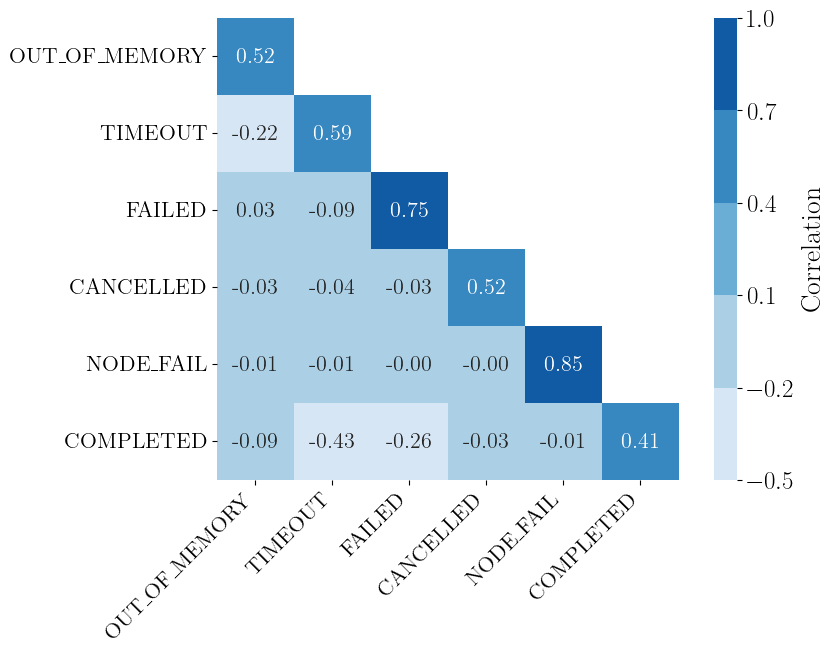

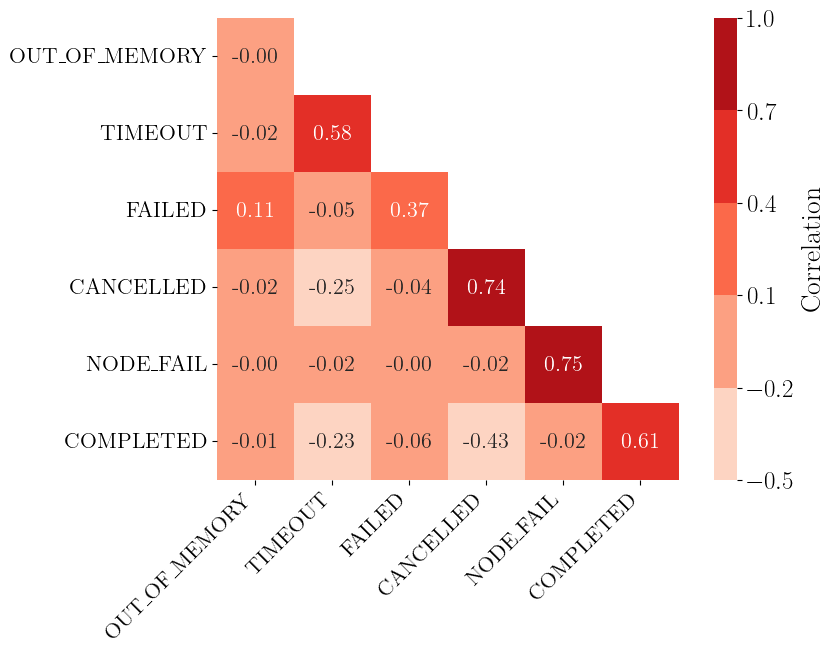

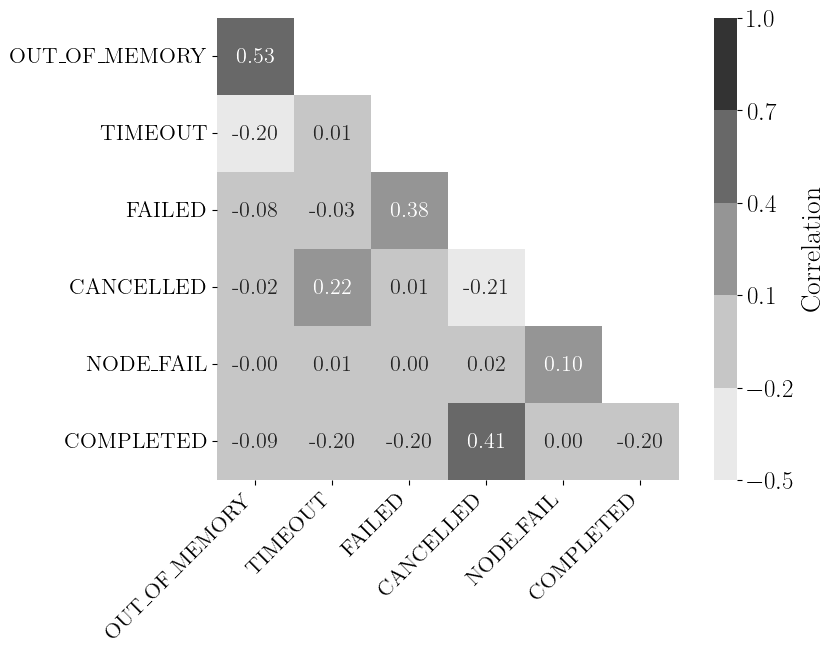

In [11]:
set_one_column_figure_font(height_multiplier=1.0)

show_concurrent_job_corr_triangle(subset_corr_matrix_generic_high_load_nodes, 'Generic High Load Nodes', sns.color_palette("Blues", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_generic_high_load_nodes')
show_concurrent_job_corr_triangle(subset_corr_matrix_ml_high_load_nodes, 'ML High Load Nodes', sns.color_palette("Reds", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_ml_high_load_nodes')
show_concurrent_job_corr_triangle(subset_corr_matrix_generic_high_load_nodes - subset_corr_matrix_ml_high_load_nodes, 'Difference High Load Nodes', sns.color_palette("Greys", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_diff_high_load_nodes')